#![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Log Analysis Lab: Web Server Log Analysis with Apache Spark**
 
This lab will demonstrate how easy it is to perform web server log analysis with Apache Spark.
 
Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information.  Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.  This homework will show you how to use Apache Spark on real-world text-based production logs and fully harness the power of that data.  Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

**How to complete this assignment**
 
This assignment is broken up into sections with bite-sized examples for demonstrating Spark functionality for log processing. For each problem, you should start by thinking about the algorithm that you will use to *efficiently* process the log in a parallel, distributed manner. This means using the various [RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) operations along with [`lambda` functions](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions) that are applied at each worker.
 
This assignment consists of 4 parts:

- *Part 1*: Apache Web Server Log file format
- *Part 2*: Sample Analyses on the Web Server Log File
- *Part 3*: Analyzing Web Server Log File
- *Part 4*: Exploring 404 Response Codes

#### **Part 1: Apache Web Server Log file format**

The log files that we use for this assignment are in the [Apache Common Log Format (CLF)](http://httpd.apache.org/docs/1.3/logs.html#common). The log file entries produced in CLF will look something like this:
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
Each part of this log entry is described below.

* `127.0.0.1` : This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.
 
* `-` : The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.
 
* `-` : The "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.
 
* `[01/Aug/1995:00:00:01 -0400]` : The time that the server finished processing the request. The format is:
`[day/month/year:hour:minute:second timezone]`
  * day = 2 digits
  * month = 3 letters
  * year = 4 digits
  * hour = 2 digits
  * minute = 2 digits
  * second = 2 digits
  * zone = (\+ | \-) 4 digits
 
* `"GET /images/launch-logo.gif HTTP/1.0"` : This is the first line of the request string from the client. It consists of a three components: the request method (e.g., `GET`, `POST`, etc.), the endpoint (a [Uniform Resource Identifier](http://en.wikipedia.org/wiki/Uniform_resource_identifier)), and the client protocol version.
 
* `200` : This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification ([RFC 2616](https://www.ietf.org/rfc/rfc2616.txt) section 10).
 
* `1839` : The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).
 
Note that log files contain information supplied directly by the client, without escaping. Therefore, it is possible for malicious clients to insert control-characters in the log files, *so care must be taken in dealing with raw logs.*
 
**NASA-HTTP Web Server Log**

For this assignment, we will use a data set from NASA Kennedy Space Center WWW server in Florida. The full [data set](http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) is freely available and contains two month's of all HTTP requests. We are using a subset that only contains several hours worth of requests. Please download [apache.log](https://raw.githubusercontent.com/hkust-comp4651-2018f/assets/master/assignment-4/apache.log) and upload it to Databricks. (You could find the instructions for uploading in the warmup notebook.) 

**(1a) Parsing Each Log Line**

Using the CLF as defined above, we create a regular expression pattern to extract the nine fields of the log line using the Python regular expression [`search` function](https://docs.python.org/2/library/re.html#regular-expression-objects). The function returns a pair consisting of a Row object and 1. If the log line fails to match the regular expression, the function returns a pair consisting of the log line string and 0. A '-' value in the content size field is cleaned up by substituting it with 0. The function converts the log line's date string into a Python `datetime` object using the given `parse_apache_time` function.

In [3]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [4]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

**(1b) Configuration and Initial RDD Creation**

We are ready to specify the input log file and create an RDD containing the parsed log file data. The log file has already been downloaded for you.
 
To create the primary RDD that we'll use in the rest of this assignment, we first load the text file using [`sc.textfile(logFile)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile) to convert each line of the file into an element in an RDD.

Next, we use [`map(parseApacheLogLine)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map) to apply the parse function to each element (that is, a line from the log file) in the RDD and turn each line into a pair [`Row` object](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Row).

Finally, we cache the RDD in memory since we'll use it throughout this notebook.

In [6]:
import sys
import os
from test_helper import Test

logFile = 'dbfs:/FileStore/tables/apache.log'

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 3
Invalid logline: 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid logline: nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid logline: ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Read 43177 lines, successfully parsed 43174 lines, failed to parse 3 lines

**(1c) Data Cleaning**

Notice that there are a large number of log lines that failed to parse. Examine the sample of invalid lines and compare them to the correctly parsed line, an example is included below. Based on your observations, alter the `APACHE_ACCESS_LOG_PATTERN` regular expression below so that the failed lines will correctly parse, and press `Shift-Enter` to rerun `parseLogs()`.
 
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
If you not familar with Python regular expression [`search` function](https://docs.python.org/2/library/re.html#regular-expression-objects), now would be a good time to check up on the [documentation](https://developers.google.com/edu/python/regular-expressions). One tip that might be useful is to use an online tester like http://pythex.org or http://www.pythonregex.com. To use it, copy and paste the regular expression string below (located between the single quotes ') and test it against one of the 'Invalid logline' above.

In [8]:
# TODO: Replace <FILL IN> with appropriate code

# This was originally '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)\s*(\S+)\s*[\S*\s*]*(\S*)" (\d{3}) (\S+)'

parsed_logs, access_logs, failed_logs = parseLogs()

Read 43177 lines, successfully parsed 43177 lines, failed to parse 0 lines

In [9]:
# TEST Data cleaning (1c)
Test.assertEquals(failed_logs.count(), 0, 'incorrect failed_logs.count()')
Test.assertEquals(parsed_logs.count(), 43177 , 'incorrect parsed_logs.count()')
Test.assertEquals(access_logs.count(), parsed_logs.count(), 'incorrect access_logs.count()')

1 test passed.
1 test passed.
1 test passed.

#### **Part 2: Sample Analyses on the Web Server Log File**
 
Now that we have an RDD containing the log file as a set of Row objects, we can perform various analyses.
 
**(2a) Example: Content Size Statistics**

Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.
 
We can compute the statistics by applying a `map` to the `access_logs` RDD. The `lambda` function we want for the map is to extract the `content_size` field from the RDD. The map produces a new RDD containing only the `content_sizes` (one element for each Row object in the `access_logs` RDD). To compute the minimum and maximum statistics, we can use [`min()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.min) and [`max()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.max) functions on the new RDD. We can compute the average statistic by using the [`reduce`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduce) function with a `lambda` function that sums the two inputs, which represent two elements from the new RDD that are being reduced together. The result of the `reduce()` is the total content size from the log and it is to be divided by the number of requests as determined using the [`count()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) function on the new RDD.

In [11]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 24992, Min: 0, Max: 1646592

**(2b) Example: Response Code Analysis**

Next, lets look at the response codes that appear in the log. As with the content size analysis, first we create a new RDD by using a `lambda` function to extract the `response_code` field from the `access_logs` RDD. The difference here is that we will use a [pair tuple](https://docs.python.org/2/tutorial/datastructures.html?highlight=tuple#tuples-and-sequences) instead of just the field itself. Using a pair tuple consisting of the response code and 1 will let us count how many records have a particular response code. Using the new RDD, we perform a [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) function. `reduceByKey` performs a reduce on a per-key basis by applying the `lambda` function to each element, pairwise with the same key. We use the simple `lambda` function of adding the two values. Then, we cache the resulting RDD and create a list by using the [`take`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) function.

In [13]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList
Test.assertEquals(len(responseCodeToCountList), 4, 'incorrect number of response code')
Test.assertEquals(sorted(responseCodeToCountList), [ (200, 38606), (302, 1734), (304, 2631), (404, 206) ], 'incorrect count list')

Found 4 response codes
Response Code Counts: [(200, 38606), (304, 2631), (404, 206), (302, 1734)]
1 test passed.
1 test passed.

**(2c) Example: Response Code Graphing with `matplotlib`**

Now, lets visualize the results from the last example. We can visualize the results from the last example using [`matplotlib`](http://matplotlib.org/). First we need to extract the labels and fractions for the graph. We do this with two separate `map` functions with a `lambda` functions. The first `map` function extracts a list of of the response code values, and the second `map` function extracts a list of the per response code counts  divided by the total size of the access logs. Next, we create a figure with `figure()` constructor and use the `pie()` method to create the pie plot.

In [15]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[200, 304, 404, 302]
[0.89413345067976, 0.060935220140352506, 0.004771058665493202, 0.04016027051439424]

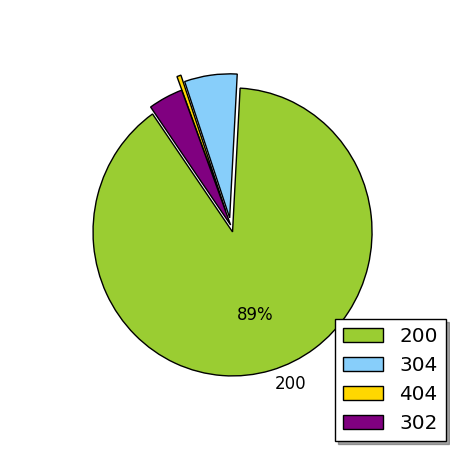

In [16]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple']
explode = (0.05, 0.05, 0.1, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)

display(fig)
pass

**(2d) Example: Frequent Hosts**

Let's look at hosts that have accessed the server multiple times (e.g., more than ten times). As with the response code analysis in (2b), first we create a new RDD by using a `lambda` function to extract the `host` field from the `access_logs` RDD using a pair tuple consisting of the host and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then filter the result based on the count of accesses by each host (the second element of each pair) being greater than ten. Next, we extract the host name by performing a `map` with a `lambda` function that returns the first element of each pair. Finally, we extract 20 elements from the resulting RDD - *note that the choice of which elements are returned is not guaranteed to be deterministic.*

In [18]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20
# An example: [u'drjo002a099.embratel.net.br', u'n2o.phantom.com', u'sl137.active.ch', u'ppp179.aix.or.jp', u'168.95.123.108', u'ix-tam1-26.ix.netcom.com', u'ppp010.st.rim.or.jp', u'buffnet5.buffnet.net', u'129.11.224.6', u'node156.silcom.com', u'simonb.hip.cam.org', u's254n068ppp49.csun.edu', u'eic66.fiu.edu', u'cygnus.omsi.edu', u'sbd0124.deltanet.com', u'hub10.hub.co.uk', u'ix-sac2-02.ix.netcom.com', u'ix-pl1-27.ix.netcom.com', u'205.233.242.127', u'ip217.pom.primenet.com']

Any 20 hosts that have accessed more then 10 times: [u'drjo002a099.embratel.net.br', u'n2o.phantom.com', u'sl137.active.ch', u'ppp179.aix.or.jp', u'168.95.123.108', u'ix-tam1-26.ix.netcom.com', u'ppp010.st.rim.or.jp', u'buffnet5.buffnet.net', u'129.11.224.6', u'node156.silcom.com', u'simonb.hip.cam.org', u's254n068ppp49.csun.edu', u'eic66.fiu.edu', u'cygnus.omsi.edu', u'sbd0124.deltanet.com', u'hub10.hub.co.uk', u'ix-sac2-02.ix.netcom.com', u'ix-pl1-27.ix.netcom.com', u'205.233.242.127', u'ip217.pom.primenet.com']

**(2e) Example: Visualizing Endpoints**

Now, lets visualize the number of hits to endpoints (URIs) in the log. To perform this task, we first create a new RDD by using a `lambda` function to extract the `endpoint` field from the `access_logs` RDD using a pair tuple consisting of the endpoint and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then cache the results.
 
Next we visualize the results using `matplotlib`. We previously imported the `matplotlib.pyplot` library, so we do not need to import it again. We perform two separate `map` functions with `lambda` functions. The first `map` function extracts a list of endpoint values, and the second `map` function extracts a list of the visits per endpoint values. Next, we create a figure with `figure()` constructor, set various features of the plot (axis limits, grid lines, and labels), and use the `plot()` method to create the line plot.

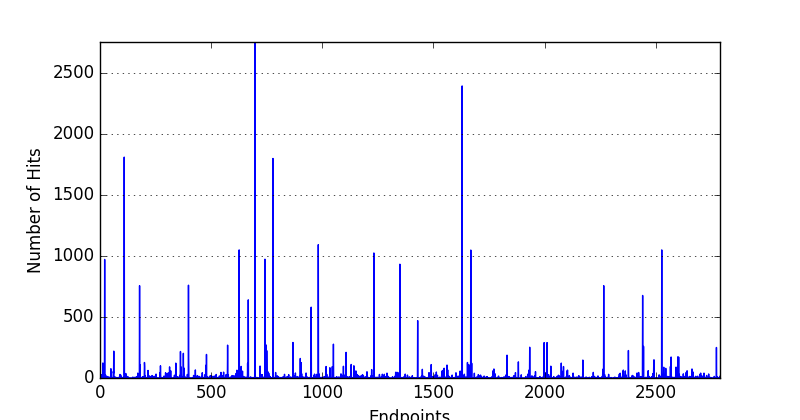

In [20]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
display(fig)

**(2f) Example: Top Endpoints**

For the final example, we'll look at the top endpoints (URIs) in the log. To determine them, we first create a new RDD by using a `lambda` function to extract the `endpoint` field from the `access_logs` RDD using a pair tuple consisting of the endpoint and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then extract the top ten endpoints by performing a [`takeOrdered`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.takeOrdered) with a value of 10 and a `lambda` function that multiplies the count (the second element of each pair) by -1 to create a sorted list with the top endpoints at the bottom.

In [22]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print 'Top Ten Endpoints: %s' % topEndpoints
Test.assertEquals(topEndpoints, 
                  [(u'/images/NA.SA-logosmall.gif', 2752), (u'/images/KSC-logosmall.gif', 2392), 
                   (u'/shuttle/countdown/count.gif', 1809), (u'/shuttle/countdown/', 1798), 
                   (u'/shuttle/missions/sts-71/sts-71-patch-small.gif', 1092), (u'/images/ksclogo-medium.gif', 1049), 
                   (u'/images/MOSAIC-logosmall.gif', 1049), (u'/images/USA-logosmall.gif', 1048), 
                   (u'/images/WORLD-logosmall.gif', 1024), (u'/images/launch-logo.gif', 973)], 
                  'incorrect Top Ten Endpoints')

Top Ten Endpoints: [(u'/images/NASA-logosmall.gif', 2752), (u'/images/KSC-logosmall.gif', 2392), (u'/shuttle/countdown/count.gif', 1809), (u'/shuttle/countdown/', 1798), (u'/shuttle/missions/sts-71/sts-71-patch-small.gif', 1092), (u'/images/ksclogo-medium.gif', 1049), (u'/images/MOSAIC-logosmall.gif', 1049), (u'/images/USA-logosmall.gif', 1048), (u'/images/WORLD-logosmall.gif', 1024), (u'/images/launch-logo.gif', 973)]
1 test failed. incorrect Top Ten Endpoints

#### **Part 3: Analyzing Web Server Log File**
 
Now it is your turn to perform analyses on web server log files.

**(3a) Exercise: Top Five Error Endpoints**

What are the top five endpoints which did not have return code 200? Create a sorted list containing top ten endpoints and the number of times that they were accessed with non-200 return code.
 
Think about the steps that you need to perform to determine which endpoints did not have a 200 return code, how you will uniquely count those endpoints, and sort the list.
 
You might want to refer back to the Word Count Lab for insights.

In [25]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Each of these <FILL IN> below could be completed with a single transformation or action.
# You are welcome to structure your solution in a different way, so long as
# you ensure the variables used in the next Test section are defined (ie. endpointSum, topFiveErrURLs).

not200 = access_logs.filter(lambda x: x.response_code != 200)

endpointCountPairTuple = not200.map(lambda x: (x.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda x, y: x + y)

topFiveErrURLs = endpointSum.takeOrdered(5, lambda (x, y): -y)
print 'Top Five failed URLs: %s' % topFiveErrURLs

Top Five failed URLs: [(u'/images/NASA-logosmall.gif', 468), (u'/images/KSC-logosmall.gif', 294), (u'/shuttle/countdown/liftoff.html', 199), (u'/shuttle/countdown/', 141), (u'/shuttle/countdown/count.gif', 140)]

In [26]:
# TEST Top five error endpoints (3a)
Test.assertEquals(endpointSum.count(), 1369, 'incorrect count for endpointSum')
Test.assertEquals(topFiveErrURLs, 
                  [(u'/images/NASA-logosmall.gif', 468), (u'/images/KSC-logosmall.gif', 294), 
                   (u'/shuttle/countdown/liftoff.html', 199), (u'/shuttle/countdown/', 141),
                   (u'/shuttle/countdown/count.gif', 140)], 
                  'incorrect Top Ten failed URLs (topFiveErrURLs)')

1 test passed.
1 test passed.

**(3b) Exercise: Number of Unique Hosts**

How many unique hosts are there in the entire log?
 
Think about the steps that you need to perform to count the number of different hosts in the log.

In [28]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Do you recall the tips from (3a)? Each of these <FILL IN> could be an transformation or action.

hosts = access_logs.map(lambda x: (x.host, 1))

uniqueHosts = hosts.reduceByKey(lambda x, y: x + y)

uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: %d' % uniqueHostCount

Unique hosts: 3597

In [29]:
# TEST Number of unique hosts (3b)
Test.assertEquals(uniqueHostCount, 3597, 'incorrect uniqueHostCount')

1 test passed.

**(3c) Exercise: Number of Unique Hourly Hosts**

For an advanced exercise, let's determine the number of unique hosts in the entire log on a hour-by-hour basis. This computation will give us counts of the number of unique hourly hosts. We'd like a list sorted by increasing hour which includes the hour of the day and the associated number of unique hosts for that hour. Make sure you cache the resulting RDD `hourlyHosts` so that we can reuse it in the next exercise.
 
Think about the steps that you need to perform to count the number of different hosts that make requests *each* hour.

*Since the log only covers a single day, you can ignore the day.*

In [31]:
# TODO: Replace <FILL IN> with appropriate code

hourToHostPairTuple = access_logs.map(lambda x: (x.date_time.hour, x.host))

hourGroupedHosts = (hourToHostPairTuple
                    .distinct()
                    .groupByKey()
                    .map(lambda iterator: list(iterator))
                    .sortByKey())

hourlyHosts = (hourGroupedHosts
               .map(lambda (k, v_it): (k, len(v_it)))
               .cache())
              
hourlyHostsList = hourlyHosts.collect()
print 'Unique hosts per hour: %s' % hourlyHostsList

Unique hosts per hour: [(0, 378), (1, 329), (2, 263), (3, 194), (4, 179), (5, 156), (6, 165), (7, 170), (8, 211), (9, 245), (10, 328), (11, 323), (12, 280), (13, 306), (14, 317), (15, 351), (16, 362), (17, 112)]

In [32]:
# TEST Number of unique hourly hosts (3c)
Test.assertEquals(hourlyHosts.count(), 18, 'incorrect hourlyHosts.count()')
Test.assertEquals(hourlyHostsList, [(0, 378), (1, 329), (2, 263), (3, 194), (4, 179), (5, 156), (6, 165), (7, 170), (8, 211), (9, 245), (10, 328), (11, 323), (12, 280), (13, 306), (14, 317), (15, 351), (16, 362), (17, 112)], 'incorrect hourlyHostsList')
Test.assertTrue(hourlyHosts.is_cached, 'incorrect hourlyHosts.is_cached')

1 test passed.
1 test passed.
1 test passed.

**(3d) Exercise: Visualizing the Number of Unique Hourly Hosts**

Using the results from the previous exercise, use `matplotlib` to plot a "Line" graph of the unique hosts requests by hour.

`hoursWithHosts` should be a list of hours and `hosts` should be a list of number of unique hosts for each corresponding hour.

* How could you convert a RDD into a list? See the [`collect()` method](http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=collect#pyspark.RDD.collect)*

In [34]:
# TODO: Replace <FILL IN> with appropriate code

hoursWithHosts = hourlyHosts.map(lambda x: x[0]).collect()
hosts = hourlyHosts.map(lambda s: s[1]).collect()

In [35]:
# TEST Visualizing unique hourly hosts (3d)
test_hours = range(0, 18)
Test.assertEquals(hoursWithHosts, test_hours, 'incorrect hours')
Test.assertEquals(hosts, [378, 329, 263, 194, 179, 156, 165, 170, 211, 245, 328, 323, 280, 306, 317, 351, 362, 112], 'incorrect hosts')

1 test passed.
1 test passed.

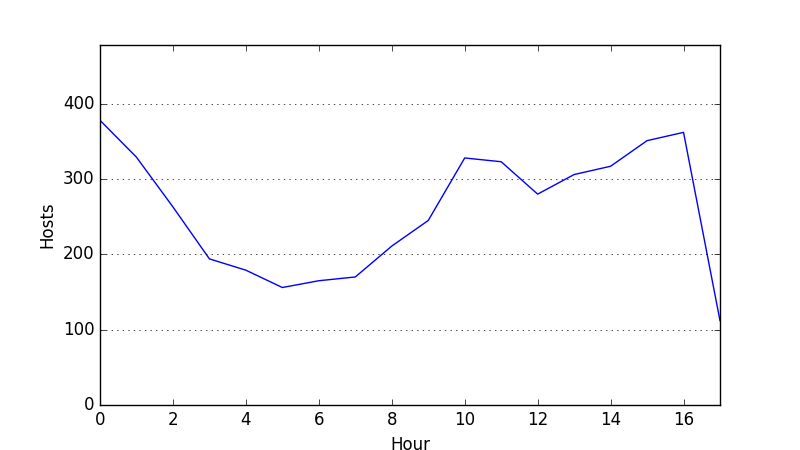

In [36]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(hoursWithHosts), max(hoursWithHosts), 0, max(hosts)+100])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('Hosts')
plt.plot(hoursWithHosts, hosts)
display(fig)

**(3e) Exercise: Average Number of Hourly Requests per Host**

Next, let's determine the average number of requests on a hour-by-hour basis. We'd like a list by increasing hour of the day and the associated average number of requests per host for that hour. Make sure you cache the resulting RDD `avgHourlyReqPerHost` so that we can reuse it in the next exercise.

To compute the average number of requests per host, get the total number of request across all hosts and divide that by the number of unique hosts.

*Since the log only covers a single day, you can skip checking for the day.*

*Also to keep it simple, when calculating the approximate average use the integer value - you do not need to upcast to float*

In [38]:
# TODO: Replace <FILL IN> with appropriate code
hourToHostPairTuple = access_logs.map(lambda x: (x.date_time.hour, x.host))
hourAndHostTuple = access_logs.map(lambda x: (x.date_time.hour, 1))

groupedByHour = hourAndHostTuple.reduceByKey(lambda x, y: x + y)

from operator import add

avgHourlyReqPerHost = (groupedByHour.join(hourlyHosts).mapValues(lambda x: x[0]/x[1])).sortByKey().cache()
avgHourlyReqPerHostList = avgHourlyReqPerHost.take(18)
print 'Average number of hourly requests per Hosts is %s' % avgHourlyReqPerHostList

Average number of hourly requests per Hosts is [(0, 9), (1, 9), (2, 8), (3, 8), (4, 8), (5, 8), (6, 9), (7, 9), (8, 9), (9, 8), (10, 9), (11, 10), (12, 9), (13, 10), (14, 9), (15, 9), (16, 8), (17, 6)]

In [39]:
# TEST Average number of hourly requests per hosts (3e)
Test.assertEquals(avgHourlyReqPerHostList, [(0, 9), (1, 9), (2, 8), (3, 8), (4, 8), (5, 8), (6, 9), (7, 9), (8, 9), (9, 8), (10, 9), (11, 10), (12, 9), (13, 10), (14, 9), (15, 9), (16, 8), (17, 6)], 'incorrect avgHourlyReqPerHostList')
Test.assertTrue(avgHourlyReqPerHost.is_cached, 'incorrect avgHourlyReqPerHost.is_cache')

1 test passed.
1 test passed.

**(3f) Exercise: Visualizing the Average Hourly Requests per Unique Host**

Using the result `avgHourlyReqPerHost` from the previous exercise, use `matplotlib` to plot a "Line" graph of the average hourly requests per unique host by hour.

`hoursWithAvg` should be a list of hours and `avgs` should be a list of average hourly requests per unique hosts for each corresponding hour.

In [41]:
# TODO: Replace <FILL IN> with appropriate code

hoursWithAvg = avgHourlyReqPerHost.keys().collect()
avgs = avgHourlyReqPerHost.values().collect()

In [42]:
# TEST Average Hourly Requests per Unique Host (3f)
Test.assertEquals(hoursWithAvg, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'incorrect hours')
Test.assertEquals(avgs, [9, 9, 8, 8, 8, 8, 9, 9, 9, 8, 9, 10, 9, 10, 9, 9, 8, 6], 'incorrect avgs')

1 test passed.
1 test passed.

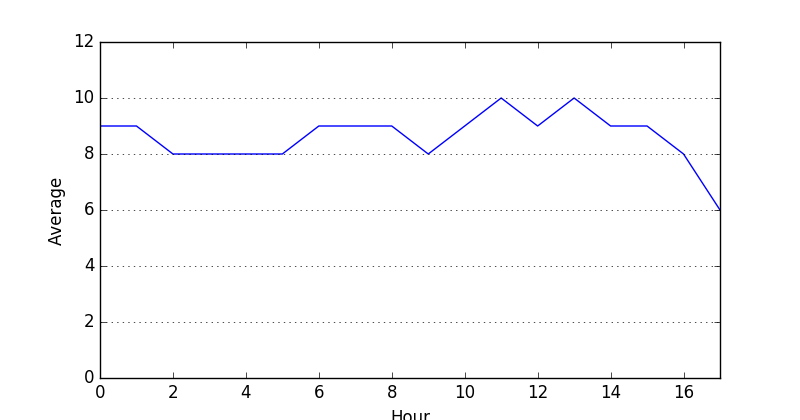

In [43]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('Average')
plt.plot(hoursWithAvg, avgs)
display(fig)

#### **Part 4: Exploring 404 Response Codes**
 
Let's drill down and explore the error 404 response code records. 404 errors are returned when an endpoint is not found by the server (i.e., a missing page or object).

**(4a) Exercise: Counting 404 Response Codes**

Create a RDD containing only log records with a 404 response code. Make sure you `cache()` the RDD `badRecords` as we will use it in the rest of this exercise.
 
How many 404 records are in the log?

In [46]:
# TODO: Replace <FILL IN> with appropriate code

badRecords = access_logs.filter(lambda x: x.response_code == 404).cache()
print 'Found %d 404 URLs' % badRecords.count()

Found 206 404 URLs

In [47]:
# TEST Counting 404 (4a)
Test.assertEquals(badRecords.count(), 6185, 'incorrect badRecords.count()')
Test.assertTrue(badRecords.is_cached, 'incorrect badRecords.is_cached')

1 test failed. incorrect badRecords.count()
1 test failed. incorrect badRecords.is_cached

In [48]:
print badRecords.take(1)

[Row(client_identd=u'-', content_size=0L, date_time=datetime.datetime(1995, 7, 1, 0, 1, 12), endpoint=u'/news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt', host=u'dd15-062.compuserve.com', method=u'GET', protocol=u'', response_code=404, user_id=u'-')]

**(4b) Exercise: Listing 404 Response Code Records**

Using the RDD containing only log records with a 404 response code that you cached in part (4a), print out a list up to 30 **distinct** endpoints that generate 404 errors -  *no endpoint should appear more than once in your list.*

In [50]:
# TODO: Replace <FILL IN> with appropriate code

badEndpoints = badRecords.map(lambda x: x.endpoint)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick30 = badUniqueEndpoints.take(30)
print '404 URLS: %s' % badUniqueEndpointsPick30

404 URLS: [u'/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', u'/history/apollo/pad-abort-test-1/news/', u'/shuttle/missions/sts-71/image/', u'/history/apollo/pad-abort-test-1/movies/', u'/lcc.jpg', u'/shuttle/missions/sts-86/mission-sts-86.html', u':/facilities/tour.html', u'/images/home_igloo.gif', u'/payloads/systems.html', u'/shuttle/missions/sts-80/mission-sts-80.html', u'/history/apollo/pad-abort-test-1/docs/', u'/://spacelink.msfc.nasa.gov', u'/people/nasa-cm/jmd.html', u'/shuttle/missions/sts-71/images/KSC-95EC-0889.jpg', u'/history/history.hrml', u'/shuttle/missions/sts-79/mission-sts-79.html', u'/mdss/ped/acs/MDSS.html', u'/news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt', u'/:/spacelink.msfc.nasa.gov', u'/software/techdoc/td-2.3.html', u'/shuttle/missions/sts-77/sts-77-press-kit.txt', u'/shuttle/missions/sts-XX/mission-sts-XX.html', u'/misc/home.map?44,104', u'/shuttle/missions/sts-68/ksc-upclose.gif', u'/ksc/', u'/shuttle/mirvis.html', u'/count.gif', u'/persons/astronauts/q-to-t/TrulyRH.txt', u'/ads/eds2_ad.gif', u'/Business/']

In [51]:
# TEST Listing 404 records (4b)

badUniqueEndpointsSet30 = set(badUniqueEndpointsPick30)
Test.assertEquals(len(badUniqueEndpointsSet30), 30, 'badUniqueEndpointsPick30 not distinct')

1 test passed.

**(4c) Exercise: Listing the Top Ten 404 Response Code Endpoints**

Using the RDD containing only log records with a 404 response code that you cached in part (4a), print out a list of the top ten endpoints that generate the most 404 errors.

*Remember, top endpoints should be in sorted order*

In [53]:
# TODO: Replace <FILL IN> with appropriate code

badEndpointsCountPairTuple = badRecords.map(lambda x: (x.endpoint, 1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda x, y: x + y)

badEndpointsTop10 = badEndpointsSum.top(10, lambda (k, v): v)
print 'Top Twenty 404 URLs: %s' % badEndpointsTop10

Top Twenty 404 URLs: [(u'/pub/winvn/readme.txt', 20), (u'/pub/winvn/release.txt', 19), (u'/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', 14), (u'/shuttle/resources/orbiters/atlantis.gif', 13), (u'/history/apollo/publications/sp-350/sp-350.txt~', 12), (u'/://spacelink.msfc.nasa.gov', 5), (u'/misc/showcase/personal_edition/images/milan_banner.gif', 5), (u'/people/nasa-cm/jmd.html', 4), (u'/shuttle/missions/sts-XX/mission-sts-XX.html', 4), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 4)]

In [54]:
# TEST Top twenty 404 URLs (4c)
Test.assertEquals(badEndpointsTop10, 
                  [(u'/pub/winvn/readme.txt', 20), (u'/pub/winvn/release.txt', 19), 
                   (u'/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', 14), (u'/shuttle/resources/orbiters/atlantis.gif', 13), 
                   (u'/history/apollo/publications/sp-350/sp-350.txt~', 12), (u'/://spacelink.msfc.nasa.gov', 5), 
                   (u'/misc/showcase/personal_edition/images/milan_banner.gif', 5), (u'/people/nasa-cm/jmd.html', 4), 
                   (u'/shuttle/missions/sts-XX/mission-sts-XX.html', 4), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 4)], 
                  'incorrect badEndpointsTop20')

1 test passed.

**(4d) Exercise: Hourly 404 Response Codes**

Using the RDD `badRecords` you cached in the part (4a) and by hour of the day and in increasing order, create an RDD containing how many requests had a 404 return code for each hour of the day (midnight starts at 0). Cache the resulting RDD hourRecordsSorted and print that as a list.

In [56]:
# TODO: Replace <FILL IN> with appropriate code

hourCountPairTuple = badRecords.map(lambda x: (x.date_time.hour, 1))

from operator import add
hourRecordsSum = hourCountPairTuple.reduceByKey(add)

hourRecordsSorted = hourRecordsSum.sortByKey().cache()

errHourList = hourRecordsSorted.collect()
print 'Top hours for 404 requests: %s' % errHourList

Top hours for 404 requests: [(0, 24), (1, 10), (2, 12), (3, 16), (4, 10), (5, 9), (6, 4), (7, 2), (8, 6), (9, 3), (10, 13), (11, 23), (12, 10), (13, 13), (14, 19), (15, 17), (16, 14), (17, 1)]

In [57]:
# TEST Hourly 404 response codes (4h)
Test.assertEquals(errHourList, [(0, 24), (1, 10), (2, 12), (3, 16), (4, 10), (5, 9), (6, 4), (7, 2), (8, 6), (9, 3), (10, 13), (11, 23), (12, 10), (13, 13), (14, 19), (15, 17), (16, 14), (17, 1)], 'incorrect errHourList')
Test.assertTrue(hourRecordsSorted.is_cached, 'incorrect hourRecordsSorted.is_cached')

1 test passed.
1 test passed.

**(4e) Exercise: Visualizing the 404 Response Codes by Hour**

Using the results from the previous exercise, use `matplotlib` to plot a "Line" or "Bar" graph of the 404 response codes by hour.

In [59]:
# TODO: Replace <FILL IN> with appropriate code

hoursWithErrors404 = hourRecordsSorted.keys().collect()
errors404ByHours = hourRecordsSorted.values().collect()
print hoursWithErrors404
print errors404ByHours

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[24, 10, 12, 16, 10, 9, 4, 2, 6, 3, 13, 23, 10, 13, 19, 17, 14, 1]

In [60]:
# TEST Visualizing the 404 Response Codes by Hour (4i)
Test.assertEquals(hoursWithErrors404, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'incorrect hoursWithErrors404')
Test.assertEquals(errors404ByHours, [24, 10, 12, 16, 10, 9, 4, 2, 6, 3, 13, 23, 10, 13, 19, 17, 14, 1], 'incorrect errors404ByHours')

1 test passed.
1 test passed.

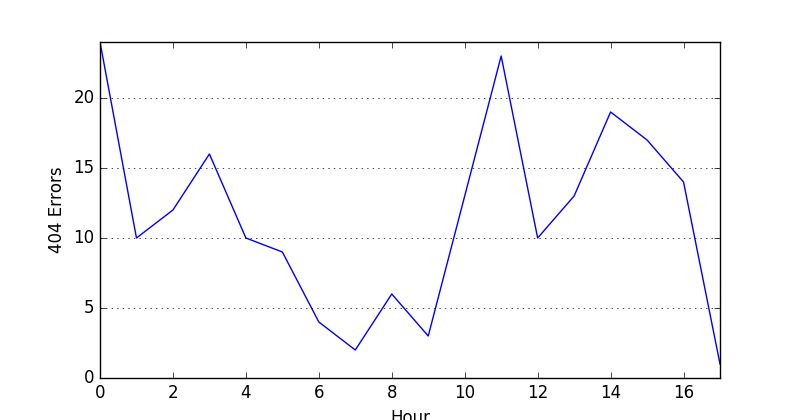

In [61]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
display(fig)